              precision    recall  f1-score   support

           0       0.67      1.00      0.81      2082
           1       0.00      0.00      0.00      1006

    accuracy                           0.67      3088
   macro avg       0.34      0.50      0.40      3088
weighted avg       0.45      0.67      0.54      3088



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


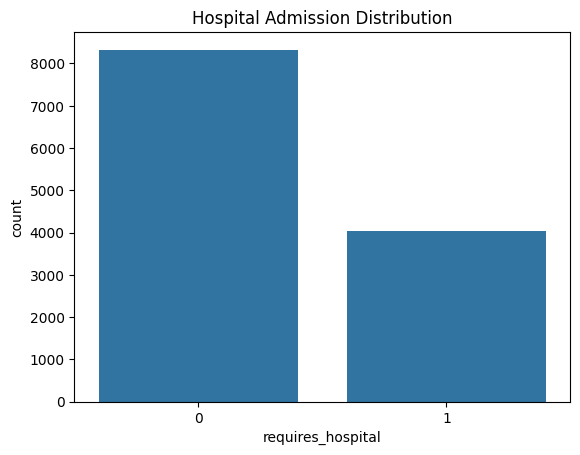


[BASIC PROMPT]
Summarize the medical data and predict hospital admission:

Patient ID: 6d65547d-e497-432f-b87e-a5cdf65ea935
Conditions: Fracture of clavicle, Cough (finding), Sputum finding (finding), Nausea (finding), Vomiting symptom (finding)
Observations: Body temperature, Respiratory rate, Heart rate, Oxygen saturation in Arterial blood, Diastolic Blood Pressure


Based on the medical data provided, the patient has a fracture of the clavicle along with symptoms of cough, sputum, nausea, and vomiting. Monitoring of body temperature, respiratory rate, heart rate, oxygen saturation, and diastolic blood pressure are also noted. Given the combination of symptoms and the need for ongoing monitoring, it is likely that the patient may require hospital admission for further evaluation and treatment.

[COT PROMPT]
Analyze step-by-step whether hospital admission is needed:

Patient ID: 6d65547d-e497-432f-b87e-a5cdf65ea935
Conditions: Fracture of clavicle, Cough (finding), Sputum finding (fi

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from openai import OpenAI  # New OpenAI SDK (>=1.0.0)

# Initialize OpenAI client
#client = OpenAI(api_key="test")  # Replace with your OpenAI key

# Load datasets
base_path = "/content"
patients = pd.read_csv(f"{base_path}/patients.csv")
conditions = pd.read_csv(f"{base_path}/conditions.csv")
observations = pd.read_csv(f"{base_path}/observations.csv")
encounters = pd.read_csv(f"{base_path}/encounters.csv")
medications = pd.read_csv(f"{base_path}/medications.csv")

# Preprocess encounter data to get hospital admission label
inpatient_ids = encounters[encounters['ENCOUNTERCLASS'] == 'inpatient']['PATIENT'].unique()
patients['requires_hospital'] = patients['Id'].isin(inpatient_ids).astype(int)

# Merge basic features
def get_initial_conditions(patient_id):
    return conditions[conditions['PATIENT'] == patient_id]['DESCRIPTION'].unique().tolist()

def get_initial_observations(patient_id):
    return observations[observations['PATIENT'] == patient_id]['DESCRIPTION'].unique().tolist()

# Build dataset for prediction
feature_data = []
for _, row in patients.iterrows():
    conds = get_initial_conditions(row['Id'])
    obs = get_initial_observations(row['Id'])
    feature_data.append({
        'Id': row['Id'],
        'conditions': ', '.join(conds[:5]),
        'observations': ', '.join(obs[:5]),
        'requires_hospital': row['requires_hospital']
    })

features_df = pd.DataFrame(feature_data)

# Encode text features using LabelEncoder for simplicity
features_df['combined'] = features_df['conditions'] + " | " + features_df['observations']
label_encoder = LabelEncoder()
features_df['combined_encoded'] = label_encoder.fit_transform(features_df['combined'])

# Train/test split
X = features_df[['combined_encoded']]
y = features_df['requires_hospital']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train a simple model
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Visualization
sns.countplot(data=features_df, x='requires_hospital')
plt.title("Hospital Admission Distribution")
plt.show()

# Generate prompt templates
def generate_prompts(summary):
    return {
        "basic": f"Summarize the medical data and predict hospital admission:\n{summary}",
        "cot": f"Analyze step-by-step whether hospital admission is needed:\n{summary}\nStep-by-step reasoning:",
        "tot": f"Use tree of thought to analyze hospitalization risk:\n{summary}\nTree of Thought:",
        "chained": f"Given the step-by-step reasoning, what is the final prediction?\n{summary}\nReasoning + Decision:",
        "simplify": f"Explain the medical situation to a non-medical person:\n{summary}\nSimplified explanation:"
    }

# Use OpenAI's new SDK
def run_inference(prompt, model="gpt-3.5-turbo"):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful medical assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"OpenAI API error: {e}"

# Sample a patient for LLM prompt generation
sample_patient = features_df.sample(1).iloc[0]
sample_summary = f"""
Patient ID: {sample_patient['Id']}
Conditions: {sample_patient['conditions']}
Observations: {sample_patient['observations']}
"""
prompts = generate_prompts(sample_summary)

# Print prompts and run inference
for key, prompt in prompts.items():
    print(f"\n[{key.upper()} PROMPT]\n{prompt}\n")
    print(run_inference(prompt))  # OpenAI response
